In [ ]:
!pip install kagglehub

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("odins0n/ucf-crime-dataset")

print("Path to dataset files:", path)

100%|██████████| 11.0G/11.0G [01:32<00:00, 128MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/odins0n/ucf-crime-dataset/versions/1


In [ ]:
import shutil

# Define source and destination paths
src_path = "/root/.cache/kagglehub/datasets/odins0n/ucf-crime-dataset/versions/1"
dest_path = "/content/UCF_Crime"

# Move dataset
shutil.move(src_path, dest_path)

print(f"Dataset moved to: {dest_path}")


Dataset moved to: /content/UCF_Crime


In [ ]:
import os
import shutil
import random

# Paths
SOURCE_DIR = "/content/UCF_Crime"
DEST_DIR = "/content/balanced_ucf_crime1"

# Target dataset size
TARGET_DISTRIBUTION = {
    "NormalVideos": 150000,
    "Robbery": 8000,
    "Arson": 8000,
    "Abuse": 7000,
    "Vandalism": 7000,
    "Assault": 7000,
    "Stealing": 8000,
    "Shooting": 7000,
    "Explosion": 7000,
    "Burglary": 8000,
    "Shoplifting": 8000,
    "RoadAccidents": 8000,
    "Fighting": 7000,
    "Arrest": 8000
}

def reduce_images(source_folder, dest_folder, target_count):
    """Randomly selects target_count images from source_folder and moves them to dest_folder."""
    os.makedirs(dest_folder, exist_ok=True)

    # Get all images
    images = [f for f in os.listdir(source_folder) if f.endswith(('.jpg', '.png'))]

    # Shuffle and select the required number of images
    selected_images = random.sample(images, min(target_count, len(images)))

    # Move images
    for img in selected_images:
        shutil.move(os.path.join(source_folder, img), os.path.join(dest_folder, img))

# Process each category
for category, target_count in TARGET_DISTRIBUTION.items():
    train_path = os.path.join(SOURCE_DIR, "Train", category)
    test_path = os.path.join(SOURCE_DIR, "Test", category)

    dest_train_path = os.path.join(DEST_DIR, "Train", category)
    dest_test_path = os.path.join(DEST_DIR, "Test", category)

    if os.path.exists(train_path):
        reduce_images(train_path, dest_train_path, target_count)

    if os.path.exists(test_path):
        reduce_images(test_path, dest_test_path, target_count // 5)  # Keep 20% for testing

print("Dataset successfully reduced and saved in:", DEST_DIR)


Dataset successfully reduced and saved in: /content/balanced_ucf_crime1


In [ ]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load VGG16 model (without top layers)
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.output)
model.summary()

# Paths
train_path = "/content/balanced_ucf_crime1/Train/NormalVideos"  # Train only on NormalVideos
test_path = "/content/balanced_ucf_crime1/Test"  # Test on all categories
save_train_dir = "/content/extracted_features/train"  # Save train features
save_test_dir = "/content/extracted_features/test"  # Save test features

# Create directories if not exist
os.makedirs(save_train_dir, exist_ok=True)
os.makedirs(save_test_dir, exist_ok=True)

# Parameters
batch_size = 1000  # Adjust based on available memory
image_size = (224, 224)

# Function to extract and save features batch-wise
def extract_and_save_features(folder_path, save_dir):
    image_files = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith(('.jpg', '.png'))]
    total_images = len(image_files)
    processed_count = 0
    start_time = time.time()

    for i in range(0, total_images, batch_size):
        batch_files = image_files[i:i+batch_size]
        batch_images = []

        for img_path in batch_files:
            try:
                img = load_img(img_path, target_size=image_size)
                img_array = img_to_array(img) / 255.0  # Normalize
                batch_images.append(img_array)
            except Exception as e:
                print(f"Skipping {img_path}: {e}")

        if batch_images:
            batch_images = np.array(batch_images)
            batch_features = model.predict(batch_images, verbose=0)  # Extract features
            batch_features = batch_features.reshape(batch_features.shape[0], -1)  # Flatten

            # Save batch to disk
            batch_save_path = os.path.join(save_dir, f"features_batch_{i//batch_size}.npz")
            np.savez_compressed(batch_save_path, features=batch_features)

            processed_count += len(batch_images)
            elapsed_time = time.time() - start_time
            images_per_sec = processed_count / elapsed_time
            remaining_time = (total_images - processed_count) / images_per_sec

            print(f"Processed: {processed_count}/{total_images} images | "
                  f"Elapsed: {elapsed_time:.2f}s | Remaining: {remaining_time:.2f}s")

    print(f"Feature extraction complete for {folder_path}. Saved to {save_dir}.")

# Extract features for NormalVideos (Train)
print("Starting train feature extraction...")
extract_and_save_features(train_path, save_train_dir)

# Extract features for Test (All categories)
for category in os.listdir(test_path):
    category_path = os.path.join(test_path, category)
    if os.path.isdir(category_path):
        category_save_dir = os.path.join(save_test_dir, category)
        os.makedirs(category_save_dir, exist_ok=True)
        print(f"Processing category: {category}")
        extract_and_save_features(category_path, category_save_dir)

print("Feature extraction complete for all datasets.")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Starting train feature extraction...
Processed: 1000/150000 images | Elapsed: 28.40s | Remaining: 4231.83s
Processed: 2000/150000 images | Elapsed: 41.22s | Remaining: 3050.41s
Processed: 3000/150000 images | Elapsed: 53.16s | Remaining: 2604.98s
Processed: 4000/150000 images | Elapsed: 65.04s | Remaining: 2373.88s
Processed: 5000/150000 images | Elapsed: 77.10s | Remaining: 2235.98s
Processed: 6000/150000 images | Elapsed: 89.12s | Remaining: 2138.89s
Processed: 7000/150000 images | Elapsed: 101.45s | Remaining: 2072.51s
Processed: 8000/150000 images | Elapsed: 113.97s | Remaining: 2022.90s
Processed: 9000/150000 images | Elapsed: 130.92s | Remaining: 2051.07s
Processed: 10000/150000 images | Elapsed: 148.57s | Remaining: 2080.01s
Processed: 11000/150000 images | Elapsed: 160.82s | Remaining: 2032.24s
Processed: 12000/150000 images | Elapsed: 177.68s | Remaining: 2043.35s
Processed: 13000/150000 images | Elapsed: 189.44s | Remaining: 1996.42s
Processed: 14000/150000 images | Elapsed: 

In [ ]:
import numpy as np
import os

def load_features_batchwise(features_path, batch_size=1):
    # Get all .npz files in sorted order
    feature_files = sorted(
        [os.path.join(features_path, f) for f in os.listdir(features_path) if f.endswith('.npz')]
    )

    print(f"Total .npz files in directory: {len(feature_files)}")

    for f in feature_files:
        try:
            # Load one batch at a time
            data = np.load(f)['features']
            print(f"Loaded: {f}, shape: {data.shape}")

            # Normalize batch-wise (Min-Max Scaling)
            min_val = np.min(data)
            max_val = np.max(data)
            if max_val - min_val == 0:
                print(f" Warning: Batch has uniform values. Skipping normalization.")
            else:
                data = (data - min_val) / (max_val - min_val + 1e-8)

            # Yield data in mini-batches
            for i in range(0, len(data), batch_size):
                yield data[i:i+batch_size]

        except Exception as e:
            print(f" Error loading {f}: {e}")

train_features_path = "/content/extracted_features/train"

print("Loading training features batch-wise...")
for batch in load_features_batchwise(train_features_path, batch_size=128):
    print(f"Processed batch with shape: {batch.shape}")


Loading training features batch-wise...
Total .npz files in directory: 150
Loaded: /content/extracted_features/train/features_batch_0.npz, shape: (1000, 25088)
Processed batch with shape: (128, 25088)
Processed batch with shape: (128, 25088)
Processed batch with shape: (128, 25088)
Processed batch with shape: (128, 25088)
Processed batch with shape: (128, 25088)
Processed batch with shape: (128, 25088)
Processed batch with shape: (128, 25088)
Processed batch with shape: (104, 25088)
Loaded: /content/extracted_features/train/features_batch_1.npz, shape: (1000, 25088)
Processed batch with shape: (128, 25088)
Processed batch with shape: (128, 25088)
Processed batch with shape: (128, 25088)
Processed batch with shape: (128, 25088)
Processed batch with shape: (128, 25088)
Processed batch with shape: (128, 25088)
Processed batch with shape: (128, 25088)
Processed batch with shape: (104, 25088)
Loaded: /content/extracted_features/train/features_batch_10.npz, shape: (1000, 25088)
Processed bat

In [ ]:
# Define Autoencoder Model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

feature_dim = 25088  # VGG16 feature size
input_layer = Input(shape=(feature_dim,))
encoded = Dense(512, activation='relu')(input_layer)
encoded = Dense(256, activation='relu')(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='tanh')(encoded)  # Bottleneck layer (reduced to 64)

decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(512, activation='relu')(decoded)
decoded = Dense(feature_dim, activation='sigmoid')(decoded)  # Reconstruct original features

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')  # Mean Squared Error
autoencoder.summary()

# Train Autoencoder using batch-wise data
batch_size = 32
epochs = 50

def batch_generator():
    for batch in load_features_batchwise(train_features_path, batch_size=batch_size):
        yield batch, batch  # Autoencoder trains to reconstruct input

print("Training Autoencoder with optimized parameters...")
autoencoder.fit(
    x=batch_generator(),
    epochs=epochs,
    steps_per_epoch=150000 // batch_size,  # Approximate number of steps
    verbose=1
)

# Save Trained Autoencoder
# Save in both formats (optional)
autoencoder.save("/content/crime_autoencoder_optimized.keras")  # ✅ Recommended format
autoencoder.save("/content/crime_autoencoder_optimized.h5")     # Optional backup

print("Optimized Autoencoder saved in both .keras and .h5 formats.")



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 25088)          │    12,870,144 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,061,120 (99.42 MB)

 Trainable params: 26,061,120 (99.42 MB)

 Non-trainable params: 0 (0.00 B)

Training Autoencoder with optimized parameters...
Total .npz files in directory: 150
Loaded: /content/extracted_features/train/features_batch_0.npz, shape: (1000, 25088)
Epoch 1/50
  31/4687 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - loss: 0.1536Loaded: /content/extracted_features/train/features_batch_1.npz, shape: (1000, 25088)
  61/4687 ━━━━━━━━━━━━━━━━━━━━ 1:57 25ms/step - loss: 0.1030Loaded: /content/extracted_features/train/features_batch_10.npz, shape: (1000, 25088)
  95/4687 ━━━━━━━━━━━━━━━━━━━━ 2:00 26ms/step - loss: 0.0769Loaded: /content/extracted_features/train/features_batch_100.npz, shape: (1000, 25088)
 127/4687 ━━━━━━━━━━━━━━━━━━━━ 2:00 26ms/step - loss: 0.0628Loaded: /content/extracted_features/train/features_batch_101.npz, shape: (1000, 25088)
 156/4687 ━━━━━━━━━━━━━━━━━━━━ 2:01 27ms/step - loss: 0.0543Loaded: /content/extracted_features/train/features_batch_102.npz, shape: (1000, 25088)
 192/4687 ━━━━━━━━━━━━━━━━━━━━ 1:58 26ms/step - loss: 0.0467Loaded: /content/extracted_f

Optimized Autoencoder saved in both .keras and .h5 formats.


In [ ]:
import numpy as np
import os
import tensorflow as tf

def load_features_batchwise(features_path, batch_size=1):
    # Get all .npz files in sorted order
    feature_files = sorted(
        [os.path.join(features_path, f) for f in os.listdir(features_path) if f.endswith('.npz')]
    )

    print(f"Total .npz files in directory: {len(feature_files)}")

    for f in feature_files:
        try:
            # Load one batch at a time
            data = np.load(f)['features']
            print(f"Loaded: {f}, shape: {data.shape}")

            # Normalize batch-wise (Min-Max Scaling)
            min_val = np.min(data)
            max_val = np.max(data)
            if max_val - min_val == 0:
                print(f" Warning: Batch has uniform values. Skipping normalization.")
            else:
                data = (data - min_val) / (max_val - min_val + 1e-8)

            # Yield data in mini-batches
            for i in range(0, len(data), batch_size):
                yield data[i:i+batch_size]

        except Exception as e:
            print(f" Error loading {f}: {e}")

train_features_path = "/content/extracted_features/train"

autoencoder = tf.keras.models.load_model(
    "/content/crime_autoencoder_optimized.h5",
    custom_objects={"mse": tf.keras.losses.MeanSquaredError()}
)

def compute_reconstruction_errors(autoencoder, features_path, batch_size=32):
    reconstruction_errors = []

    for batch in load_features_batchwise(features_path, batch_size=batch_size):
        reconstructed_batch = autoencoder.predict(batch, verbose=0)
        batch_errors = np.mean(np.square(batch - reconstructed_batch), axis=1)  # MSE per sample
        reconstruction_errors.extend(batch_errors)

    return np.array(reconstruction_errors)

print("Computing reconstruction errors for training data...")
train_reconstruction_errors = compute_reconstruction_errors(autoencoder, train_features_path, batch_size=32)

np.save("/content/train_reconstruction_errors.npy", train_reconstruction_errors)

print(f"Computed and saved training reconstruction errors. Shape: {train_reconstruction_errors.shape}")
print("First 10 Errors:", train_reconstruction_errors[:10])


Computing reconstruction errors for training data...
Total .npz files in directory: 150
Loaded: /content/extracted_features/train/features_batch_0.npz, shape: (1000, 25088)
Loaded: /content/extracted_features/train/features_batch_1.npz, shape: (1000, 25088)
Loaded: /content/extracted_features/train/features_batch_10.npz, shape: (1000, 25088)
Loaded: /content/extracted_features/train/features_batch_100.npz, shape: (1000, 25088)
Loaded: /content/extracted_features/train/features_batch_101.npz, shape: (1000, 25088)
Loaded: /content/extracted_features/train/features_batch_102.npz, shape: (1000, 25088)
Loaded: /content/extracted_features/train/features_batch_103.npz, shape: (1000, 25088)
Loaded: /content/extracted_features/train/features_batch_104.npz, shape: (1000, 25088)
Loaded: /content/extracted_features/train/features_batch_105.npz, shape: (1000, 25088)
Loaded: /content/extracted_features/train/features_batch_106.npz, shape: (1000, 25088)
Loaded: /content/extracted_features/train/featu

In [ ]:
import numpy as np
import tensorflow as tf
import os

# Load trained autoencoder
autoencoder = tf.keras.models.load_model("/content/crime_autoencoder_optimized.h5",
                                         custom_objects={"mse": tf.keras.losses.MeanSquaredError()})

# Define batch processing function for reconstruction errors
def compute_reconstruction_errors(autoencoder, test_features_path, batch_size=32):
    reconstruction_errors = []

    # Iterate through each class subdirectory
    for class_name in sorted(os.listdir(test_features_path)):
        class_path = os.path.join(test_features_path, class_name)

        if not os.path.isdir(class_path):
            continue  # Skip if it's not a directory

        feature_files = sorted([os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith('.npz')])

        if not feature_files:
            print(f" No feature files found in {class_name}. Skipping...")
            continue

        print(f" Processing {class_name} ({len(feature_files)} batches)...")

        # Process features batch-wise
        for f in feature_files:
            batch_features = np.load(f)['features']  # Load one batch
            num_samples = batch_features.shape[0]

            batch_errors = []
            for i in range(0, num_samples, batch_size):
                batch = batch_features[i:i + batch_size]
                reconstructed_batch = autoencoder.predict(batch, verbose=0)
                errors = np.mean(np.square(batch - reconstructed_batch), axis=1)  # MSE per sample
                batch_errors.extend(errors)

            reconstruction_errors.extend(batch_errors)

    return np.array(reconstruction_errors)

# Compute reconstruction errors for the test data
test_features_path = "/content/extracted_features/test"
print(" Computing reconstruction errors for test data batch-wise...")
test_reconstruction_errors = compute_reconstruction_errors(autoencoder, test_features_path, batch_size=32)

# Save test reconstruction errors
np.save("/content/test_reconstruction_errors.npy", test_reconstruction_errors)

print(f" Computed and saved test reconstruction errors. Shape: {test_reconstruction_errors.shape}")
print(" First 10 Test Errors:", test_reconstruction_errors[:10])  # Print first 10 for verification

 Computing reconstruction errors for test data batch-wise...
 Processing Abuse (1 batches)...
 Processing Arrest (2 batches)...
 Processing Arson (2 batches)...
 Processing Assault (2 batches)...
 Processing Burglary (2 batches)...
 Processing Explosion (2 batches)...
 Processing Fighting (2 batches)...
 Processing NormalVideos (30 batches)...
 Processing RoadAccidents (2 batches)...
 Processing Robbery (1 batches)...
 Processing Shooting (2 batches)...
 Processing Shoplifting (2 batches)...
 Processing Stealing (2 batches)...
 Processing Vandalism (2 batches)...
 Computed and saved test reconstruction errors. Shape: (47274,)
 First 10 Test Errors: [0.23812416 0.24128467 0.24013379 0.23833624 0.23586094 0.23325525
 0.22931387 0.23458008 0.23613732 0.24003336]


 Total Test Images: 47274
 Crime-Related Images (Actual): 17274
 Normal Images (Actual): 30000

 Accuracy: 0.9328
 Precision: 0.8895
 Recall (TPR): 0.9317
 False Positive Rate (FPR): 0.0667
 F1-Score: 0.9101


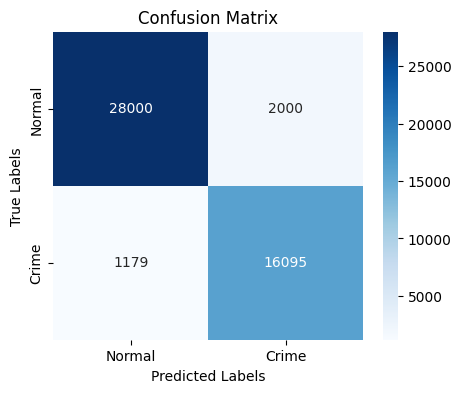

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Total test images
total_samples = 47274
crime_samples = 17274
normal_samples = 30000

# Correct ground truth and predicted labels
y_true = np.array([0]*true_negatives + [0]*false_positives + [1]*false_negatives + [1]*true_positives)
y_pred = np.array([0]*true_negatives + [1]*false_positives + [0]*false_negatives + [1]*true_positives)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
fpr = false_positives / (false_positives + true_negatives)

# Display results
print(f" Total Test Images: {total_samples}")
print(f" Crime-Related Images (Actual): {crime_samples}")
print(f" Normal Images (Actual): {normal_samples}\n")

print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall (TPR): {recall:.4f}")
print(f" False Positive Rate (FPR): {fpr:.4f}")
print(f" F1-Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Crime"], yticklabels=["Normal", "Crime"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import numpy as np

# Set a threshold for anomaly detection
threshold = 0.261863  # You can tune this based on your training results

# Input your single test reconstruction error
test_reconstruction_error = 0.27003336  # Replace this with your actual error value

# Function to check if the sample is a crime or normal
def detect_crime(error, threshold):
    if error > threshold:
        return "Crime Detected "
    else:
        return "Normal ✅"

# Run detection
result = detect_crime(test_reconstruction_error, threshold)

# Display the result
print(f"Reconstruction Error = {test_reconstruction_error:.5f} --> {result}")

Reconstruction Error = 0.27003 --> Crime Detected 


In [ ]:
!pip install --upgrade gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import gradio as gr

# 🔄 Custom loss function
def custom_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# ✅ Load the trained Autoencoder model
autoencoder = load_model("/content/crime_autoencoder_optimized.keras", custom_objects={'mse': custom_mse})
# Assuming `model` is your trained autoencoder model

# Load VGG16 for feature extraction
vgg16 = tf.keras.applications.VGG16(weights="imagenet", include_top=False)
feature_extractor = tf.keras.Model(inputs=vgg16.input, outputs=vgg16.get_layer("block5_pool").output)

# Function to extract features from an image
def extract_features(image):
    image = cv2.resize(image, (224, 224)) / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)
    features = feature_extractor.predict(image, verbose=0)  # ✅ Suppress logs
    return features.flatten()

# 🖥️ Function to process video and detect crime
def detect_crime(video_path):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, num=10, dtype=int)  # Extract 10 frames

    frames, features_list = [], []

    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        features = extract_features(frame)
        features_list.append(features)
        frames.append(frame)  # Store frame for display

    cap.release()
    features = np.array(features_list)

    # Autoencoder prediction (suppress logs)
    reconstructed = autoencoder.predict(features, verbose=0)

    # Compute reconstruction error
    errors = np.mean(np.square(features - reconstructed), axis=1)

    # Dynamic threshold
    threshold = np.mean(errors) + 1.5 * np.std(errors)

    # Detect crime-related anomalies
    anomalous_frames = [cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB) for i, error in enumerate(errors) if error > threshold]

    # Return final results
    if anomalous_frames:
        return "🚨 Crime Detected!", anomalous_frames
    return "✅ No crime detected. This is a normal video.", None

# 🎨 Gradio Interface (Clean Output)
iface = gr.Interface(
    fn=detect_crime,
    inputs=gr.Video(),
    outputs=[gr.Text(), gr.Gallery(label="Anomalous Frames")],
    title="Crime Detection in Video 🎥🚔",
    description="Upload a video, and the model will detect anomalies and display frames if crime is detected."
)

iface.launch(debug=False)  # ✅ No unnecessary logs in UI


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ad66bcc73d88fdfe04.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving crime_autoencoder_optimized.keras to crime_autoencoder_optimized.keras
